# Ditchley S2DS project August 2020 - Pipeline C

## Team: Adam Hawken, Luca Lamoni, Elizabeth Nicholson, Robert Webster

This notebook (C_pipeline) will be dedicated to:
C1: Package and data imports
C2: Hashtag analysis, topic assignment and searching for keywords
C3: Preprocessing for training Doc2Vec model
C4: Training Doc2Vec model and testing robustness
C5: Apply Doc2Vec to tweets and some basic analysis


## Section C1: Package and data imports

### C1.1: Package intallations

In [1]:
# installations and imports

#!pip install gensim==3.8.3
#!pip install wordcloud

import sys
import os
import itertools as it
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import decomposition as skd
from sklearn import feature_extraction as skfe
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import difflib
import nltk
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


In [2]:
# set path for calling functions
sys.path.insert(1, '../')

from src.topics import hashtag_analysis as ha
import src.plots as plots
from src.topics import preprocessing as pp
from src.topics import topic_modelling as tm

### C1.2: importing data

In [3]:
# import data

src_dir = '../data/cleaned/friends_tweets/'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))] # build list of files to iterate through

data = pd.DataFrame()

with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        data = pd.concat([data, df[['tweet_id', 'text', 'hashtags']]], axis=0)
        pbar.update(1)
        
data = data[data['hashtags'].astype(str) != '[]'] # remove empties
data['text'] = data['text'].apply(lambda x: x.lower() if isinstance(x, str) else '')
data = data[data.text != '']

Files: 100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38it/s]


## Section C2: Hashtag analysis, topic assignment and keyword searches

### C2.1 Hashtag analysis

In [4]:
# vectorize the hashtags

hashtag_observations = ha.vectorize_wordlists(data['hashtags'])
hashtag_observations.info()
hashtag_observations.sparse.density

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40357 entries, 1 to 21570
Columns: 19704 entries, 00020f to 𝗬𝗙𝗜𝗞𝗼𝘀𝗼𝘃𝗼
dtypes: Sparse[int64, 0](19704)
memory usage: 1.3 MB


0.00011315095798822146

Sum of the explained variance = 0.337.


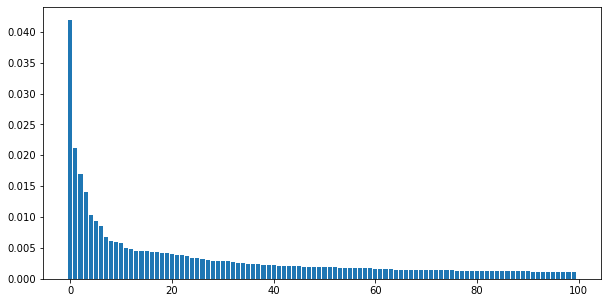

In [5]:
# Use TruncatedSVD on vectorised documents as dimensionality reduction to generate topics.

hashtag_dimred, svd_comps = ha.SVD_on_vectors(hashtag_observations, n_components=100)

In [6]:
# make topic keywords

topics = ha.make_topic_keywords_from_svd(svd_comps, threshold=0.2)
topics.head(50)

,keywords
topic,
0,"[cybersecurity, infosec]"
1,"[ai, artificialintelligence, machinelearning]"
2,[infosec]
3,"[covid19, infosec, privacy]"
4,"[databreach, privacy, security, technology]"
5,[security]
6,"[bigdata, datascience, iot, tech, technology]"
7,"[ransomware, tech]"
8,"[virtualreality, vr]"


### C2.2 Topic assignment

In [7]:
# define topics with some human input here is necessary 

topics = [['covid19', 'lockdown', 'coronavirus', 'covid', 'pandemic'], 
['ai', 'ml', 'datascience', 'artificalintelligence', 'data', 'bigdata'], 
['cybersecurity', 'iot', 'robotics', 'infosec', 'cyber'],
['fintech', 'blockchain', 'payments', 'cryptocurrency', 'bitcoin', 'cyrpto'],
['startup', 'startups'],
['malware', 'ransomware'], 
['environment', 'health', 'mentalhealth', 'research', 'wellbeing'],
['beirut', 'belarus', 'lebanon']]

### C2.3 Searching for hashtags or keywords

In [8]:
# run this cell if you want to match the topic list with hashtags 

possible_topics = data['hashtags'].apply(lambda x: ha.check_for_matches(eval(x), topic_list=topics, number_other_topic=10))

labelled_data = data.assign(topic_labels=possible_topics.values)
labelled_data['main_label'] = labelled_data['topic_labels'].apply(lambda x: x[0])
labelled_data

,tweet_id,text,hashtags,topic_labels,main_label
1,1301442308316037120,if you re interested in immortalising soupgate...,['soupgate'],[10],10
3,1299059177474732034,oh ea what have you done to starwars and the s...,"['starwars', 'openingnightlive']",[10],10
4,1299057580774432770,we need more diversity in video game show pres...,['openingnightlive'],[10],10
12,1295467814304849920,fellow journalists please add your name to thi...,"['journalistsforbelarus', 'journorequest']",[10],10
13,1295466789443338247,just re watched pirates of silicon valley afte...,['anthonymichaelhall'],[10],10
...,...,...,...,...,...
21368,1189542533115699200,monitor github gitlab bitbucket in realtime fo...,"['github', 'gitlab', 'bugbounty', 'bugbountyti...",[10],10
21413,1300508656098709504,historyofencryption in the monk trithemius dev...,['historyofencryption'],[10],10
21445,1299361098488066049,i used the same password on multiple sites one...,['nordcybercrimestory'],[10],10
21528,1227636164288483328,rt hmm gb callofduty update downloads over ish...,"['callofduty', 'nbn']",[10],10


In [9]:
flat_topics = list(set([item for sublist in topics for item in sublist]))

In [54]:
# import data, this time finding matched for keywords

src_dir = '../data/cleaned/friends_tweets/'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))] # build list of files to iterate through

data_new= pd.DataFrame()

with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df['text'] = df['text'].apply(lambda x: x.lower() if isinstance(x, str) else '')
        df['keywords'] = df['text'].apply(lambda x: ha.check_keyword_matches(x, flat_topics))
        df = df[df['keywords'].astype(str)!='[]']
        data_new = pd.concat([data_new, df[['tweet_id', 'text', 'hashtags', 'keywords']]], axis=0, ignore_index=True)
        pbar.update(1)
        
data_new = data_new[data_new.text != '']

Files: 100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.37s/it]


In [57]:
# this is the cell to run if you want to match topics to keywords

data_new['topic_labels'] = data_new['keywords'].apply(lambda x: ha.check_for_matches(x, topics, 10))
data_new['main_label'] = data_new['topic_labels'].apply(lambda x: x[0] if len(x)>0 else 10)
data_new = pd.concat([data_new, labelled_data[labelled_data['main_label']==10]], axis=0, ignore_index=True)
data_new

,tweet_id,text,hashtags,keywords,topic_labels,main_label
0,1293641653362753537,rt i don t ask for much but once we ve lived t...,[],[pandemic],[0],0
1,1290259194864472065,the brilliant re wrote the trainspotting monol...,"['covid_19', 'covidiots', 'coviduk', 'chooseli...",[covid],[0],0
2,1285975567888678912,i had clinically significant anxiety before co...,[],[covid],[0],0
3,1285516622313263104,the long awaited russiareport has called the u...,"['russiareport', 'cyberattacks']",[cyber],[2],2
4,1283721039558500353,my goal with this was to provide an exhaustive...,['startup'],[startup],[4],4
...,...,...,...,...,...,...
55047,1189823657385705473,an unauthenticated rce in apache solr but the ...,"['unauthenticated', 'threatintel']",NaN,[10],10
55048,1189542533115699200,monitor github gitlab bitbucket in realtime fo...,"['github', 'gitlab', 'bugbounty', 'bugbountyti...",NaN,[10],10
55049,1300508656098709504,historyofencryption in the monk trithemius dev...,['historyofencryption'],NaN,[10],10
55050,1299361098488066049,i used the same password on multiple sites one...,['nordcybercrimestory'],NaN,[10],10


In [58]:
# to give an idea about how many tweets are in each topic: 
data_new.groupby('main_label').count()

,tweet_id,text,hashtags,keywords,topic_labels
main_label,,,,,
0,5532,5532,5532,5532,5532
1,6127,6127,6127,6127,6127
2,7181,7181,7181,7181,7181
3,1207,1207,1207,1207,1207
4,447,447,447,447,447
5,1489,1489,1489,1489,1489
6,2146,2146,2146,2146,2146
7,360,360,360,360,360
10,30563,30563,30563,0,30563


In [59]:
# produce a random sample of topics to train the model with
sample_df = ha.produce_random_sample(data_new, data_new['main_label'], 350)

In [60]:
# grouping by label and joining the tweets together to prepare for wordcloud plot
grouped = sample_df.groupby('main_label')['text'].agg(' '.join)

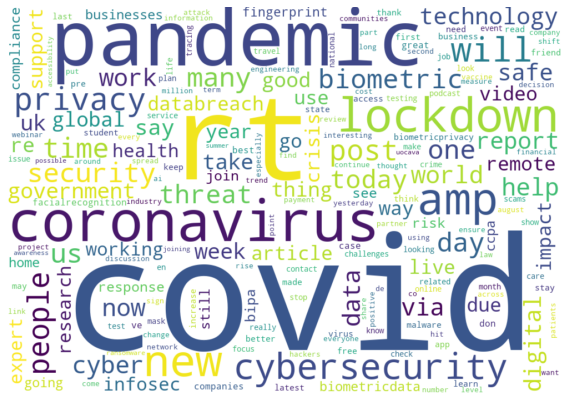

In [61]:
# plotting a wordcloud of first topic
cloudplot = plots.wordcloud_plot(grouped[0])

## C3: Preprocessing for training Doc2Vec model
A lot of code adapted from Martin's script ref: https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [62]:
# preprocessing the tweets for training (no stopword removal since Doc2Vec likes the context for semantic relations)

min_characters_sent = 3   #Min characters in a sentence (inclusive)
min_characters_word = 3     #Min characters in a word (inclusive)
test_size = 0.2     #Fraction of corpus to keep back for testing

data_new['tokens'] = data_new['text'].apply(lambda x: pp.tokenize_text(str(x), min_characters_word))


In [63]:
train, test = train_test_split(data_new[['text', 'main_label', 'tokens']], test_size=test_size, random_state=42)

train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[str(r.main_label)]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[str(r.main_label)]), axis=1)

## C4: Training Doc2Vec model and testing robustness 
### C4.1: distributed bag of words (dbow)

In [18]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores=4

In [64]:
#model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores) #Values from tutorial

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=1, min_count=2, sample=0, workers=cores)

model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|███████████████████████████████████████████████████████████████████████| 44041/44041 [00:00<00:00, 1635729.91it/s]


In [65]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 44041/44041 [00:00<00:00, 2207921.57it/s]


Wall time: 1min 41s


In [66]:
%%time
y_train, X_train = tm.vec_for_learning(model_dbow, train_tagged)
y_test, X_test = tm.vec_for_learning(model_dbow, test_tagged)

logreg_dbow = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_dbow.fit(X_train, y_train)
y_pred = logreg_dbow.predict(X_test)

print('model_dbow Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('model_dbow Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

model_dbow Testing accuracy 0.6015802379438743
model_dbow Testing F1 score: 0.5547244052953119
Wall time: 3min 29s


c:\users\rwhwe\.conda\envs\ditchley\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### C4.2: distributed memory (dmm)

In [33]:
#model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065)  #Values from tutorial

model_dmm = Doc2Vec(dm=1, dm_mean=0, vector_size=300, window=10, negative=5, min_count=1, workers=cores, alpha=0.1, min_alpha=0) #My optimised values

model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|███████████████████████████████████████████████████████████████████████| 19591/19591 [00:00<00:00, 1785735.30it/s]


In [34]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|███████████████████████████████████████████████████████████████████████| 19591/19591 [00:00<00:00, 1785502.48it/s]


Wall time: 1min 13s


In [35]:
y_train, X_train = tm.vec_for_learning(model_dmm, train_tagged)
y_test, X_test = tm.vec_for_learning(model_dmm, test_tagged)

logreg_dmm = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_dmm.fit(X_train, y_train)
y_pred = logreg_dmm.predict(X_test)

print('model_dmm Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('model_dmm Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

model_dmm Testing accuracy 0.47876684360963656
model_dmm Testing F1 score: 0.5011576959554492


c:\users\rwhwe\.conda\envs\ditchley\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### C4.3: combined pairing

In [19]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
model_new = ConcatenatedDoc2Vec([model_dbow, model_dmm])

NameError: name 'model_dbow' is not defined

In [39]:
# Model Pairing method

y_train, X_train = tm.get_vectors(model_new, train_tagged)
y_test, X_test = tm.get_vectors(model_new, test_tagged)

logreg_new = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg_new.fit(X_train, y_train)
y_pred = logreg_new.predict(X_test)

print('model_new Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('model_new Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

model_new Testing accuracy 0.6384238464679461
model_new Testing F1 score: 0.6410961843023549


c:\users\rwhwe\.conda\envs\ditchley\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### C4.4: Testing the model makes sense

In [40]:
sim = model_dmm.n_similarity(['covid'], ['coronavirus'])
sim2 = model_dmm.n_similarity(['coronavirus'], ['pandemic'])
sim3 = model_dmm.n_similarity(['coronavirus'], ['cybersecurity'])
sim4 = model_dmm.n_similarity(['cybersecurity'], ['trump'])

print("{:.4f}".format(sim))
print("{:.4f}".format(sim2))
print("{:.4f}".format(sim3))
print("{:.4f}".format(sim4))

0.7000
-0.1008
0.1100
0.0245


c:\users\rwhwe\.conda\envs\ditchley\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  """Entry point for launching an IPython kernel.
c:\users\rwhwe\.conda\envs\ditchley\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  
c:\users\rwhwe\.conda\envs\ditchley\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\rwhwe\.conda\envs\ditchley\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  after removing the cwd from sys.path.


In [41]:
similar_words = model_dmm.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)
similar_words

c:\users\rwhwe\.conda\envs\ditchley\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('approached', 0.2850656509399414),
 ('darkvishnya', 0.2844003140926361),
 ('neutralized', 0.28190338611602783)]

In [42]:
similar_words = model_dmm.most_similar(positive=['cryptocurrency', 'phishing'], negative=['security'], topn=3)
similar_words

c:\users\rwhwe\.conda\envs\ditchley\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bgp', 0.3469231128692627),
 ('infos', 0.3453250527381897),
 ('tencent', 0.3326787054538727)]

In [43]:
similar_words = model_dmm.most_similar(positive=['media', 'trump'], negative=['safety'], topn=3)
similar_words

c:\users\rwhwe\.conda\envs\ditchley\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('aesmew', 0.2682279646396637),
 ('organisational', 0.2535606622695923),
 ('leakage', 0.24821120500564575)]

## C5: Apply Doc2Vec model to tweets and some basic analysis
### C5.1: apply doc2vec to tweets

In [67]:
src_dir = '../data/cleaned/friends_tweets/'
dest_dir = '../data/processed/labelled_tweets/'

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
if not os.path.exists(dest_dir+'trained_topics/'):
    os.makedirs(dest_dir+'trained_topics/')
if not os.path.exists(dest_dir+'trained_topics_all/'):
    os.makedirs(dest_dir+'trained_topics_all/')

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
classifier_model = logreg_dbow
model = model_dbow

with tqdm(total=len(files), desc='Files') as pbar:
    i=0
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df = df[df.text != '']
        df['clean_tweet'] = df['text'].apply(lambda x: tm.clean_text(x))
        test_tagged = df.apply(
            lambda r: TaggedDocument(words=pp.tokenize_text(r['clean_tweet'], min_characters_word), tags=[r.screen_name]), axis=1)
        X_test = tm.get_vectors_apply(model, test_tagged)
        df['y_pred'] = classifier_model.predict(X_test)
        y_pred_score = classifier_model.predict_proba(X_test)
        df2 = pd.DataFrame(y_pred_score)
        df2.columns=classifier_model.classes_
        df2['score'] = df2.max(axis=1)
        df['score'] = df2['score']
        df3 = df[['tweet_id','screen_name', 'text', 'y_pred', 'score']].copy()
        df4 = pd.concat([df3, df2], axis=1)
        df3.to_csv(dest_dir+'trained_topics/tweets_trained_topic_modelled_'+str(i)+'.csv', index=False)
        df4.to_csv(dest_dir+'trained_topics_all/tweets_trained_all_topics_modelled_'+str(i)+'.csv', index=False)
        #print(df4.head())
        pbar.update(1)
        i = i+1

Files: 100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [06:39<00:00, 99.98s/it]


### C5.2: How are user's tweets spread over topics?

In [68]:
src_dir = '../data/processed/labelled_tweets/trained_topics_all'

files = [file for file in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, file))]
ls = list(logreg_dbow.classes_)
ls.insert(0, 'screen_name')
df_totalled_topics = pd.DataFrame(columns=ls)

list(df_totalled_topics)

['screen_name', '0', '1', '10', '2', '3', '4', '5', '6', '7']

In [73]:
with tqdm(total=len(files), desc='Files') as pbar:
    for file in files:
        df = pd.read_csv(os.path.join(src_dir, file), low_memory=False)
        df1 = df.groupby('screen_name')[df_totalled_topics.columns.tolist()[1:]].sum()
        df_totalled_topics = pd.concat([df_totalled_topics, df1])
        pbar.update(1)
df_totalled_topics['screen_name'] = df_totalled_topics.index
df_totalled_topics.head(10)


Files: 100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.03it/s]


,screen_name,0,1,10,2,3,4,5,6,7
20000streets,20000streets,10.835648,9.115404,65.284911,5.487661,2.664758,1.622184,0.937065,3.234332,0.818039
70s_party,70s_party,7.159145,6.873609,72.383957,5.595999,3.468707,1.557318,1.161364,1.265425,0.534476
_alexhirsch,_alexhirsch,9.834966,10.253222,66.410442,4.955455,3.397095,1.044138,1.504531,1.944397,0.655753
_choobacca,_choobacca,10.121174,11.421374,64.582132,6.096349,1.881561,0.963871,1.053954,3.284190,0.595393
_lucasrizzotto,_lucasrizzotto,7.857370,10.250216,66.323867,8.131891,2.039540,0.706807,1.484690,2.951718,0.253902
_lucyingham,_lucyingham,10.569158,9.911133,65.762717,7.092200,1.723386,1.142862,1.159103,2.387717,0.251724
_mediacontacts,_mediacontacts,5.307753,7.988215,77.852142,4.225555,1.575784,0.250345,0.455985,2.263485,0.080737
ad_nauseum74,ad_nauseum74,8.612177,11.816600,60.298376,10.140405,1.635224,0.570154,1.227490,5.363840,0.335735
adamsconsulting,adamsconsulting,6.050777,7.855361,73.134988,6.565135,2.158363,1.154464,0.685056,2.047837,0.348021
adanielhill,adanielhill,7.450329,8.944876,63.503315,11.589590,3.839362,1.663877,1.218271,1.107794,0.682586


In [84]:
df_totalled_topics['total'] = df_totalled_topics.sum(axis = 1)
df2 = df_totalled_topics[df_totalled_topics.columns.tolist()[1:]].div(df_totalled_topics.total, axis=0)
df2 = df2.reset_index()
df2 = df2.rename(columns={'index': 'user_name'})
df2.columns = ['user_name', 'Covid19', 'AI', 'Other', 'Cybersecurity', 'Financial_tech_cyrptocurrency', 'Startup', 'malware', 'environment', 'beirut', 'total']

In [85]:
df2.to_csv('../data/outputs/user_name_topics_summed.csv', index=False)

In [90]:
df3 = df2.set_index('user_name')
df3 = df3.drop('total', axis=1)

<AxesSubplot:title={'center':'Oxchich'}>

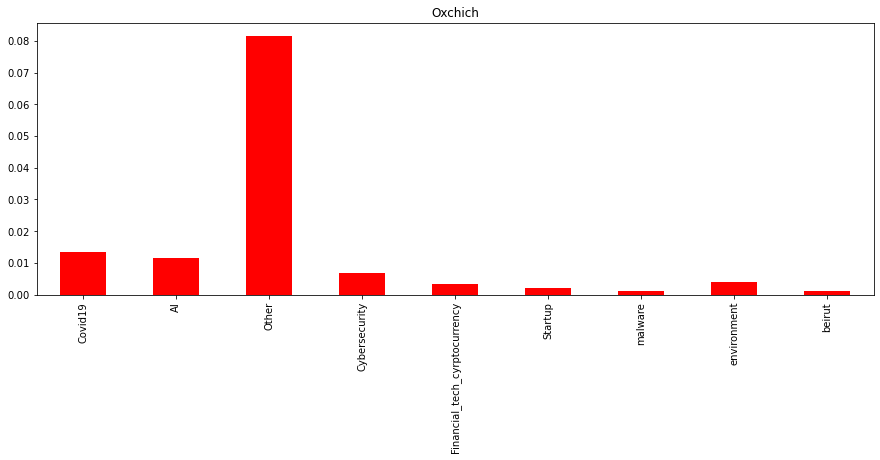

In [91]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.iloc[0]
row1.plot(kind='bar',title='Oxchich', color='r',stacked=False, figsize=(15,5))

<AxesSubplot:title={'center':'gcluley'}, xlabel='user_name'>

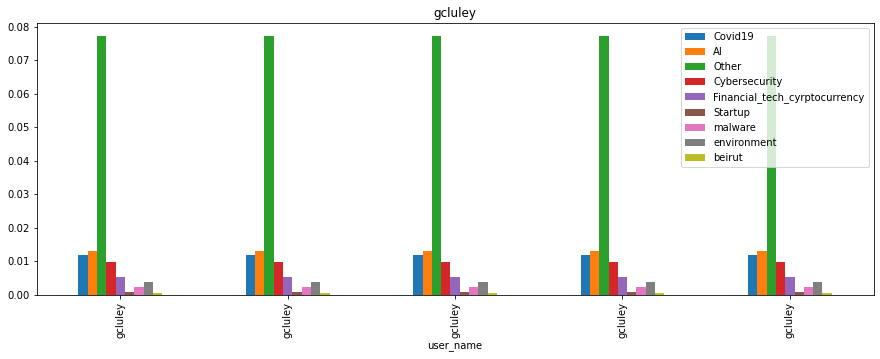

In [93]:
x = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
labels = list(df3.columns)
row1 = df3.loc['gcluley']
row1.plot(kind='bar',title='gcluley', stacked=False, figsize=(15,5))

### C5.3: Who is the maximum tweeter in each topic?

In [ ]:
print(df3['Covid19'].idxmax(), )
print(df3['A.I.'].idxmax(), )
print(df3['Cybersecurity'].idxmax(), )
print(df3['Financial tech/cyrptocurrency'].idxmax(), )

In [ ]:
xlabels = [0.0, 0.1, 0.2, 0.3, 0.4,  0.5, 0.6, 0.7]
labels = ['Covid19', 'A.I.', 'Other', 'Cybersecurity', 'Financial tech/cyrptocurrency', 'Startup', 'malware', 'environment', 'beirut']
row1 = df3.loc['fuckkgirl_ck']
fig = row1.plot(kind='barh', color='r',stacked=False, figsize=(15,5))
fig.set_ylabel('Topics', fontsize=30)
fig.set_xlabel('Proportion of tweets', fontsize=30)
fig.set_yticklabels(labels, fontsize=20)
fig.set_xticklabels(xlabels, fontsize=20)
fig.set_title('fuckkgirl_ck', fontsize = 30 )
fig.figure.savefig('fuckkgirl_ck.png')